In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import scipy 
import torch
import matplotlib.pyplot as plt

import ripley



In [3]:

#define genes,molecules:
sample_number = "219KS"
coi = ["neoplastic","connective","lymphoid","smooth muscle","non-neoplastic"]   #cell types of interest
goi = []   #genes of interest

coi=sorted(coi)

#study parameter settings:
microscopy_resolution = 0.1625
ssam_um_p_px = 2.5

# sonar parameters:
max_radius=500
linear_steps=20

cell_color_file = sample_number+"_custom_colour_celltypes.csv"
coordinate_file = sample_number+"_Decoded_LowThreshold.csv"
cell_map_file = "celltypefile.npy"
data_path = os.path.join("..","..","data",sample_number,)

colors = pd.read_csv(os.path.join(data_path,cell_color_file),header=None)
colors.columns=['celltype','colors']
coordinates = pd.read_csv(os.path.join(data_path,coordinate_file))
celltype_map = np.load(os.path.join(data_path,cell_map_file)).squeeze()

colors["cluster_index"]=colors.celltype.map(lambda x: int(x.split('_')[-1][7:])).values
colors["areas"]=[(celltype_map==i).sum() for i in range(len(colors))]

plotting_colors=[colors[colors.celltype.str.startswith(ct)].iloc[-1,1] for ct in coi]

os.makedirs(f'../../output/{sample_number}',exist_ok=True)

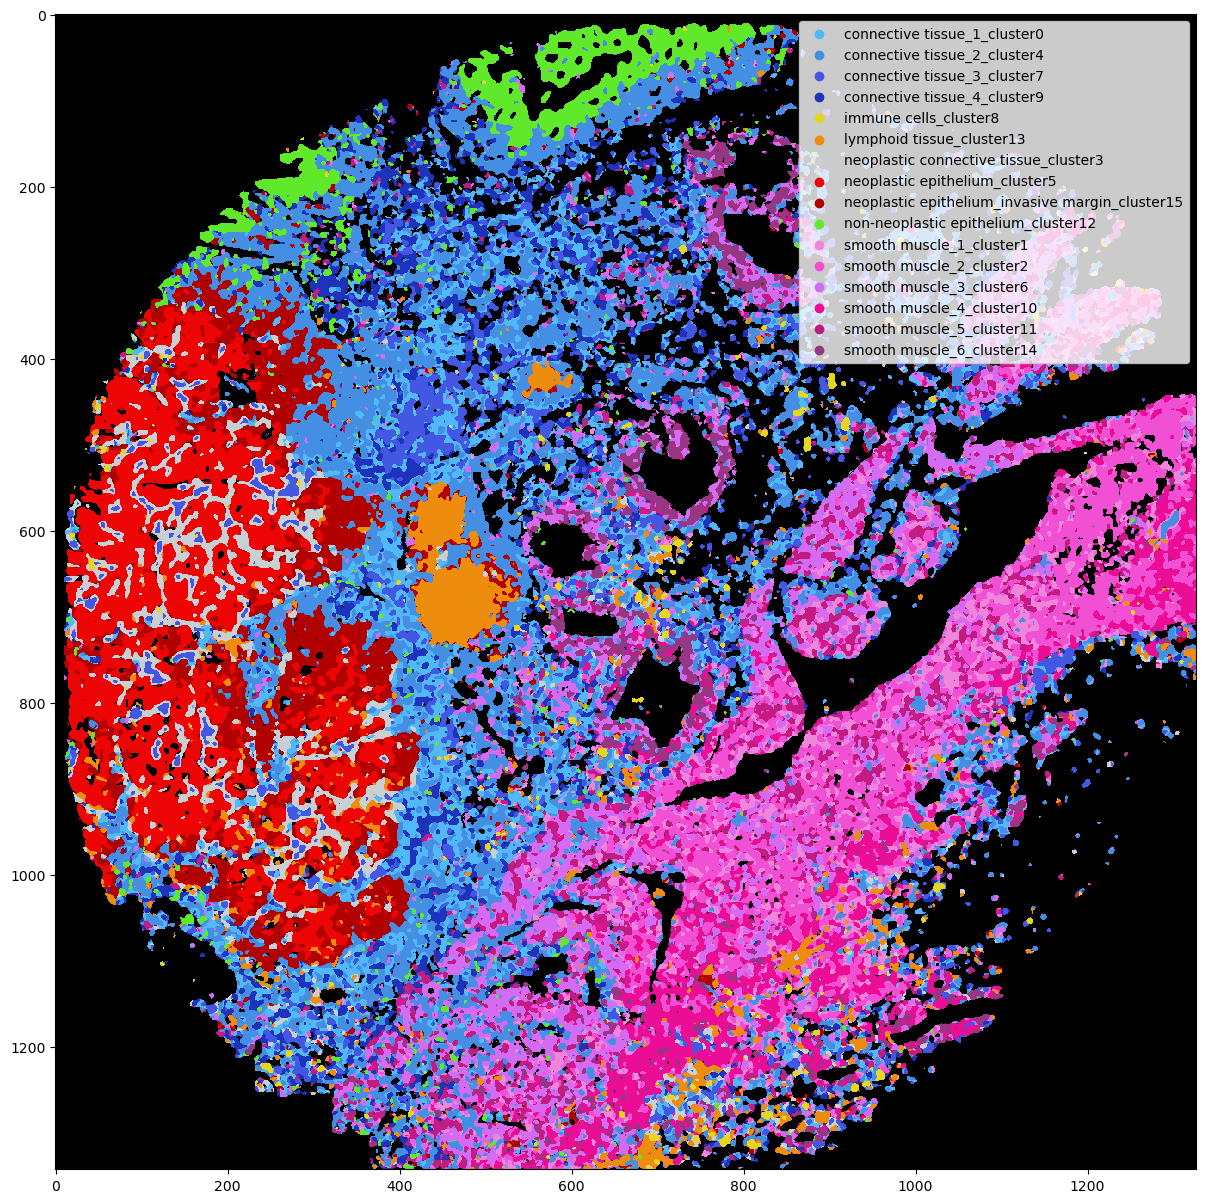

In [4]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#000000']+list(colors.colors))


plt.figure(figsize=(15,15))

plt.imshow(celltype_map,cmap=cmap,interpolation='none',vmin=-1,vmax=len(colors))

handles = [plt.scatter([],[],color=c) for c in colors.colors]
celltype_sort_idcs = np.argsort(colors.celltype.values)
plt.legend([handles[i] for i in celltype_sort_idcs],colors.celltype[celltype_sort_idcs])


In [5]:

#rescale coordinates
coordinates['X']*=microscopy_resolution/ssam_um_p_px
coordinates['Y']*=microscopy_resolution/ssam_um_p_px

celltype_matrix = np.zeros((len(goi)+len(coi),)+celltype_map.shape)


In [6]:

i=0
for ct in coi:
    tissue_idcs = np.array(colors[colors.celltype.str.startswith(ct)].cluster_index)
    for idx in tissue_idcs:
        celltype_matrix[i,:,:]+=celltype_map==idx
    i+=1



In [7]:
for g in goi:
    gene_idcs = coordinates.gene
    coordinate_subset = coordinates[coordinates.gene==g]
    kde = np.histogram2d(coordinate_subset.X,coordinate_subset.Y,
                         bins=[np.arange(s+1) for s in celltype_map.shape])
    celltype_matrix[i,:,:] = kde[0]
    i+=1
#     break

In [8]:
rip = ripley.Ripley(um_per_px=3)
coocs=rip.compute_coocurrences(cell_matrix=celltype_matrix,
                               max_radius=max_radius,linear_steps=linear_steps)
dm = rip.radial_integration()

(52, 1001, 1001)


/home/sebastian/src/ISS/scripts/sonar/ripley.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sample[:img_shape[0],:img_shape[1]] = torch.tensor(tissue_mask, dtype=torch.float, device=device)


In [9]:
# rip.run_pipeline(cell_matrix=celltype_matrix,
#                                max_radius=max_radius,linear_steps=max_radius)
# asf

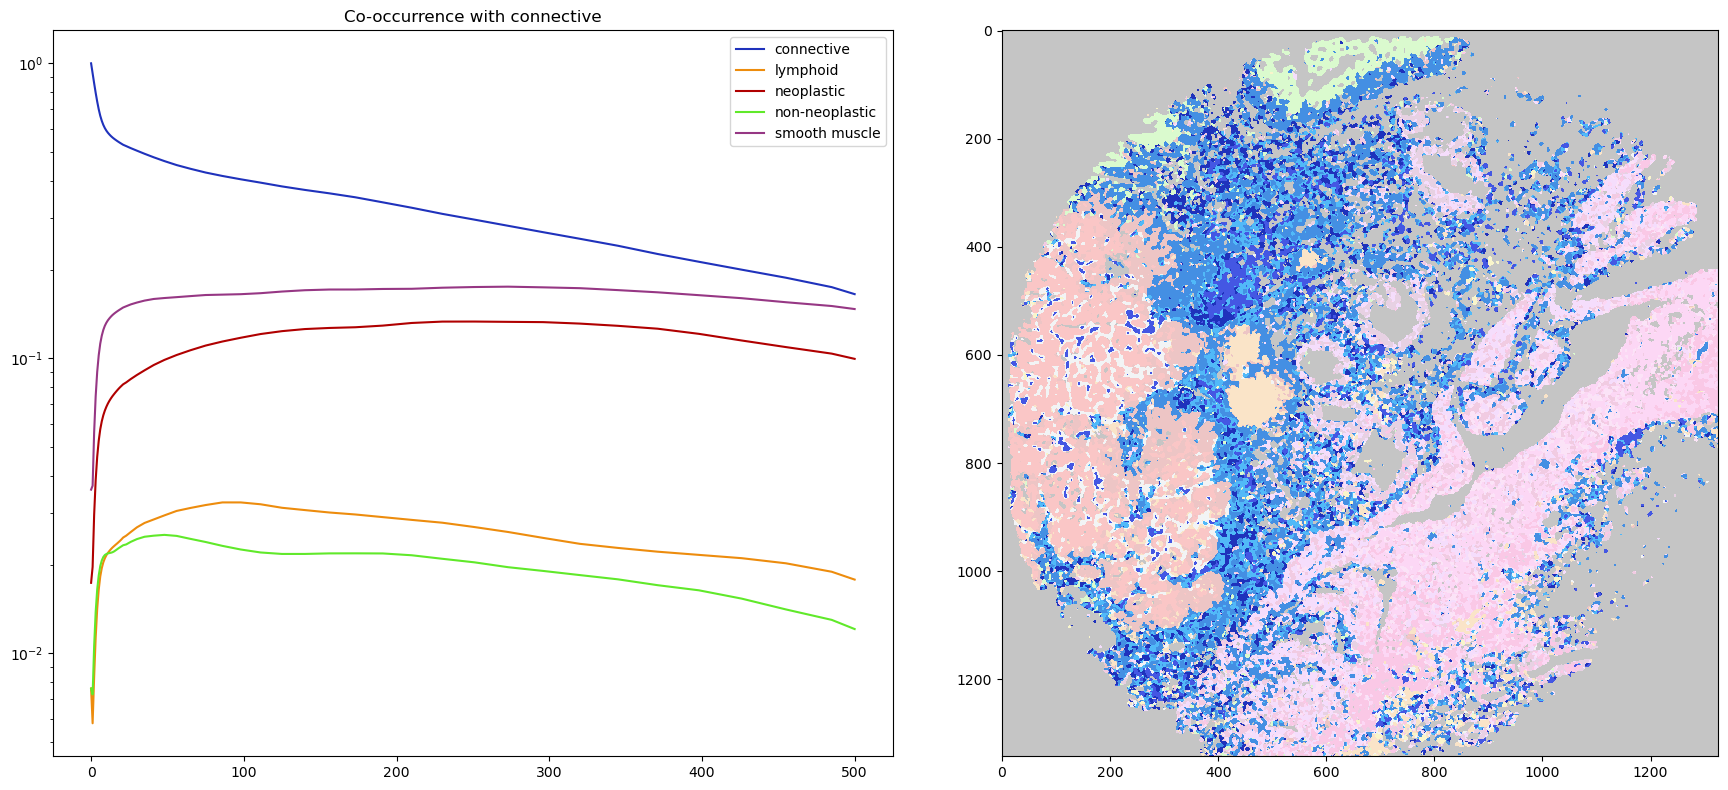

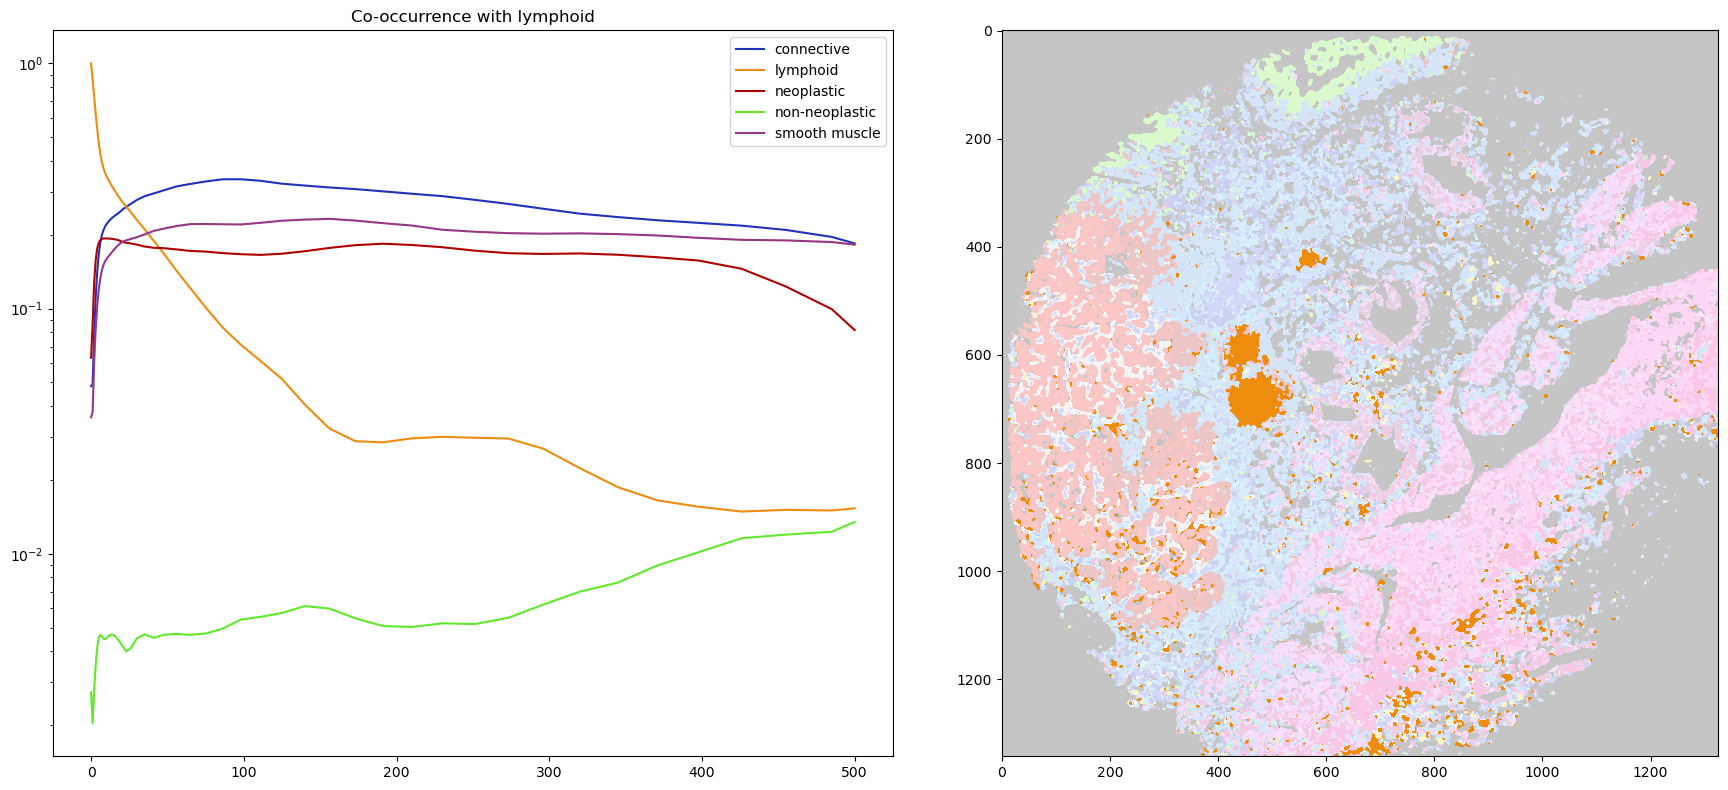

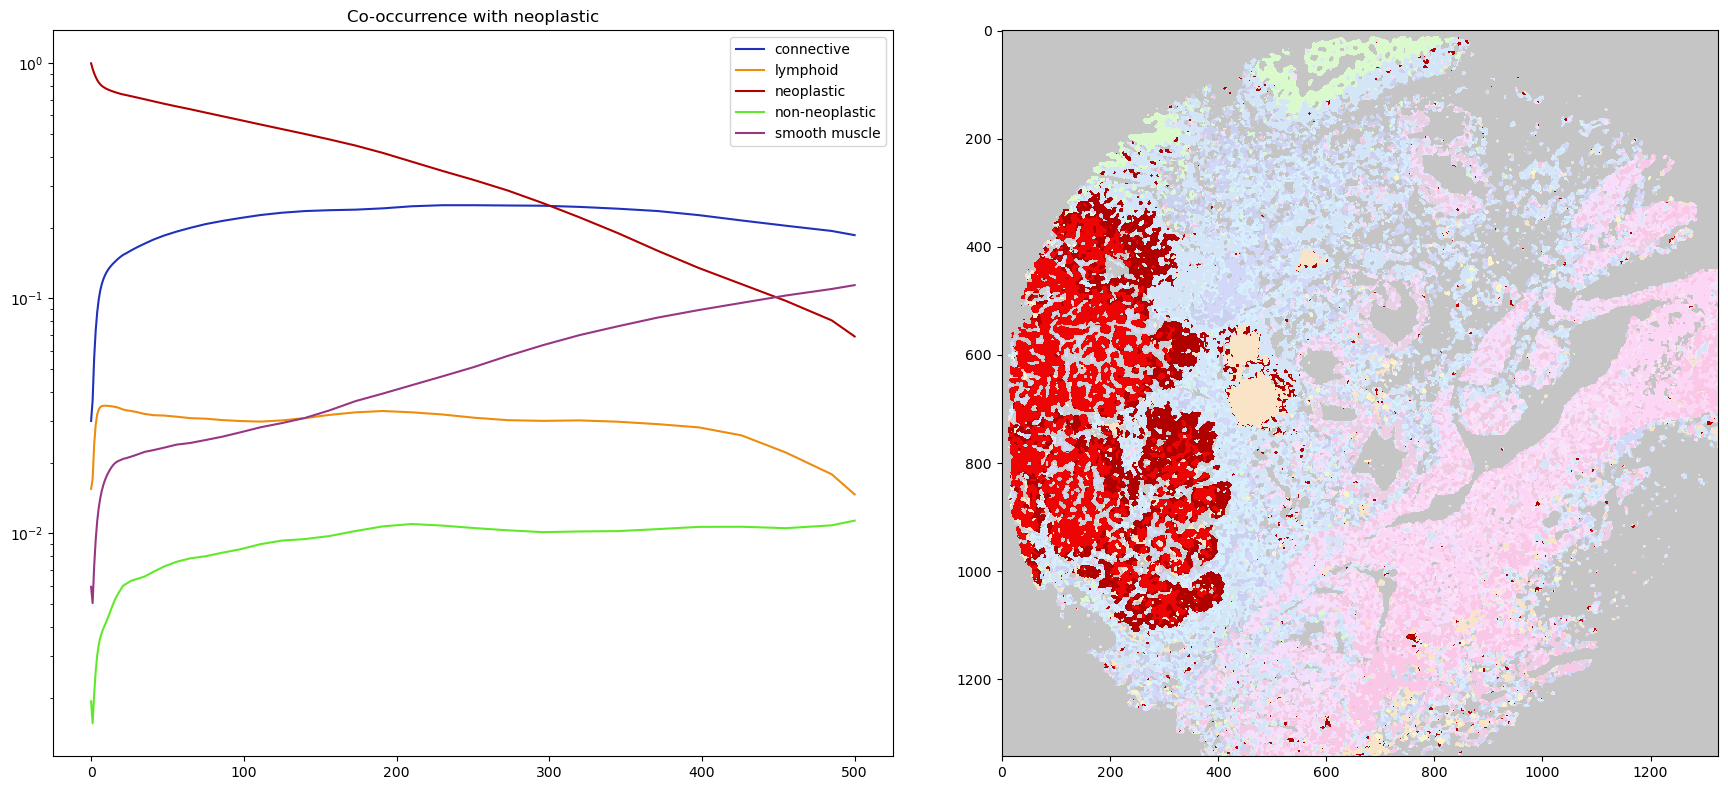

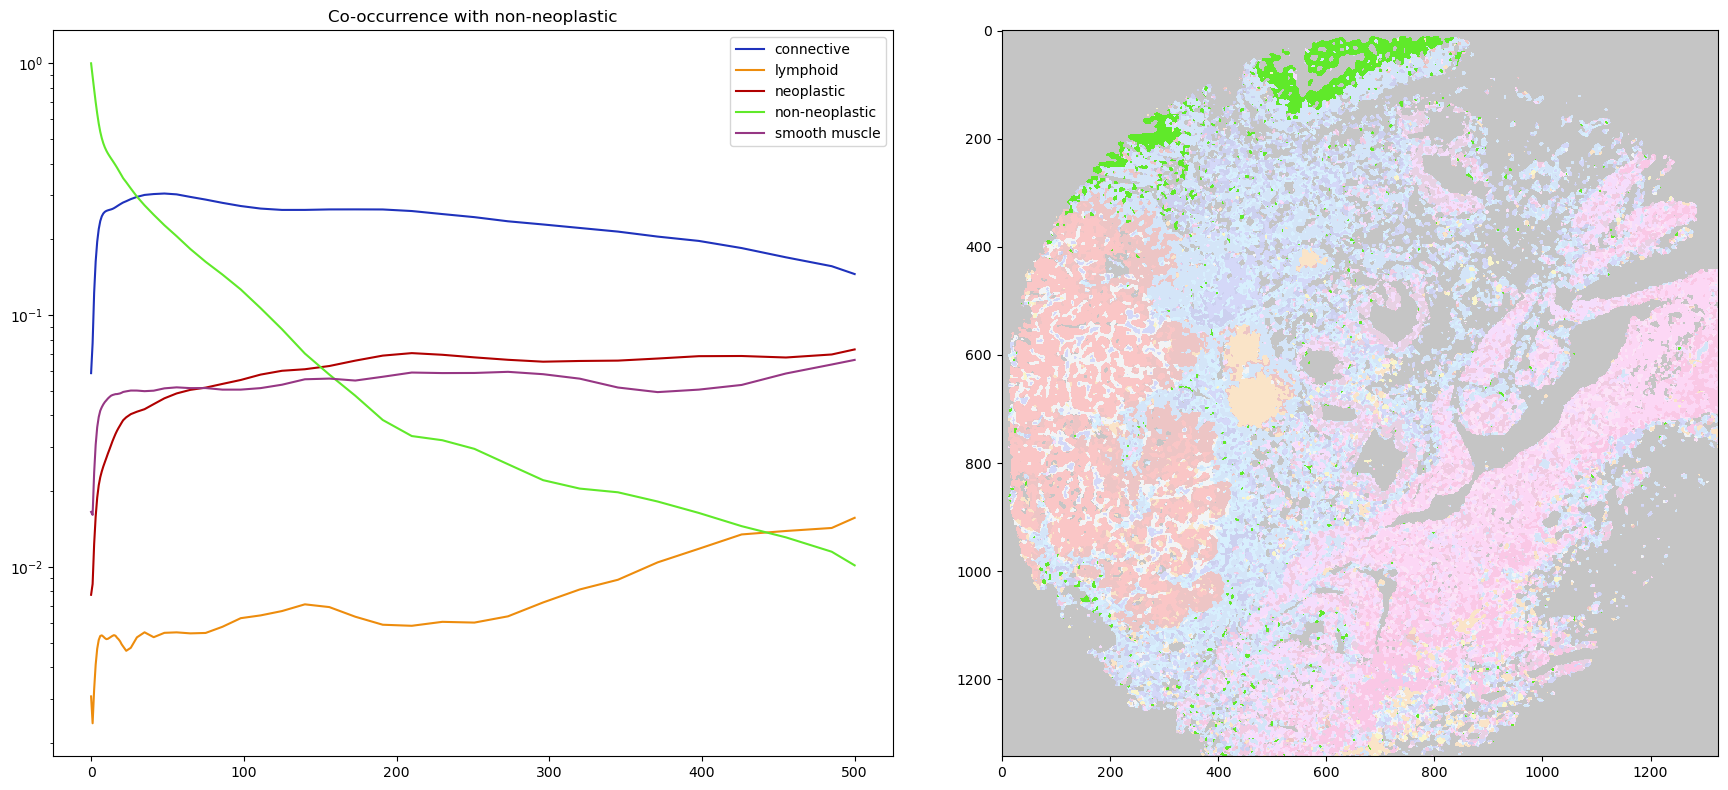

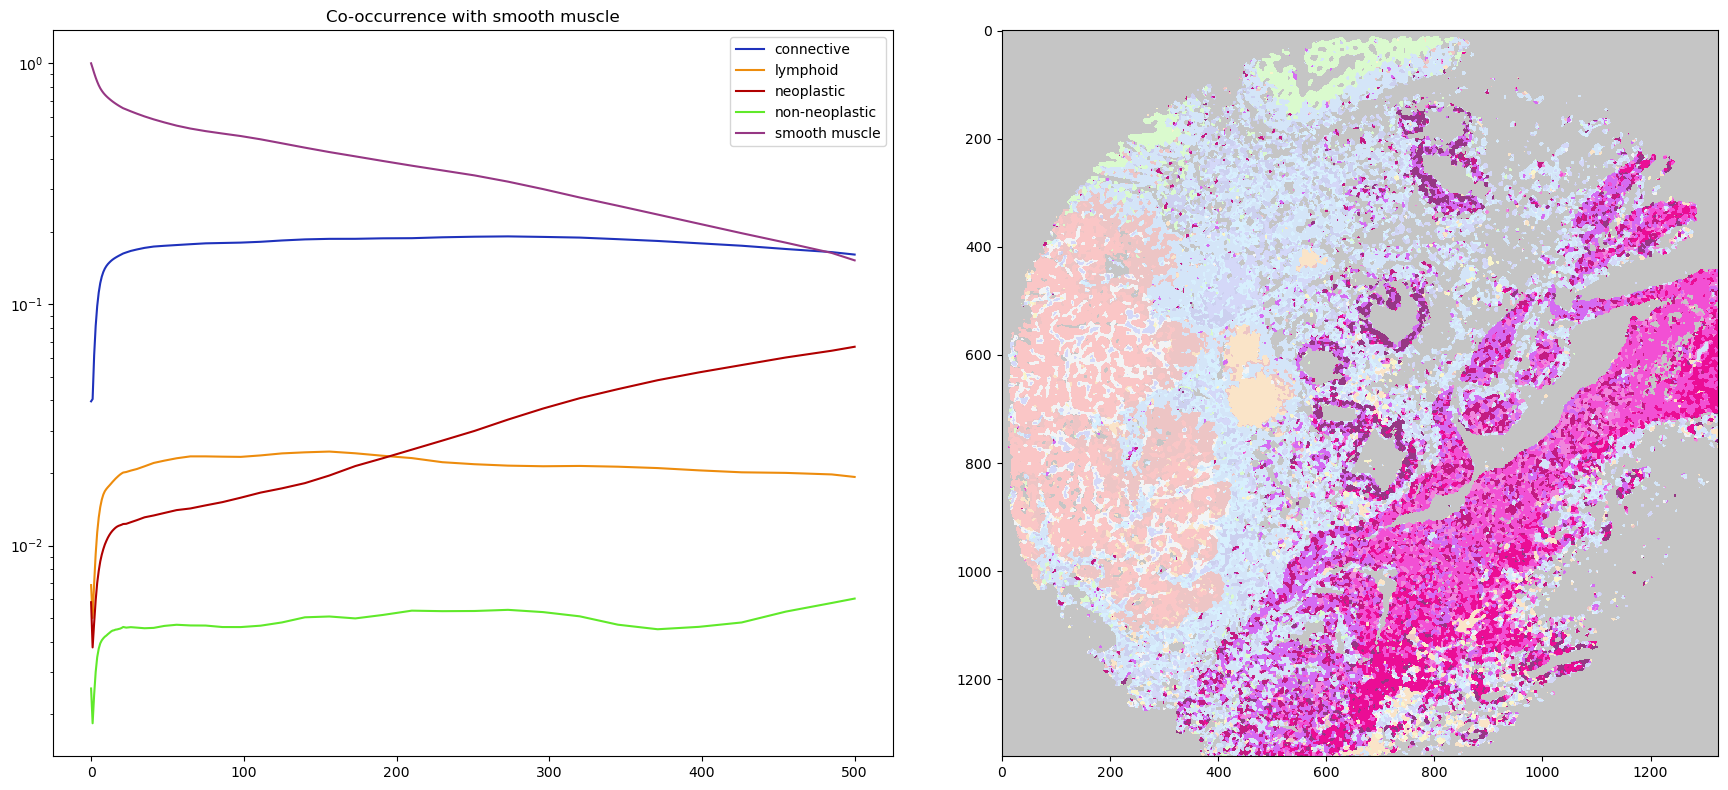

In [10]:
for reference in range(len(coi)):
    scaling_factor = rip.kernel_areas

    plt.figure(figsize=(18,8))

    plt.subplot(121)

    for i in range(dm.shape[0]):
        if i<len(plotting_colors):
            plt.plot(rip.radii, dm[reference,i]/scaling_factor/dm[reference,reference,0],color=plotting_colors[i])
        else:
            plt.plot(rip.radii, dm[reference,i]/scaling_factor/dm[reference,reference,0])

    plt.legend(coi+goi)

    plt.title('Co-occurrence with '+(coi+goi)[reference])
    plt.yscale('log')

    plt.subplot(122)

    alpha_mask = (celltype_matrix[reference]+0.3)/1.3#np.zeros_like(celltype_map).astype(float)
    plt.imshow(celltype_map,cmap=cmap,interpolation='none',vmin=-1,vmax=len(colors),alpha=alpha_mask)
    plt.tight_layout()
    plt.savefig(f'../../output/{sample_number}/{coi[reference]}_coocurrences')


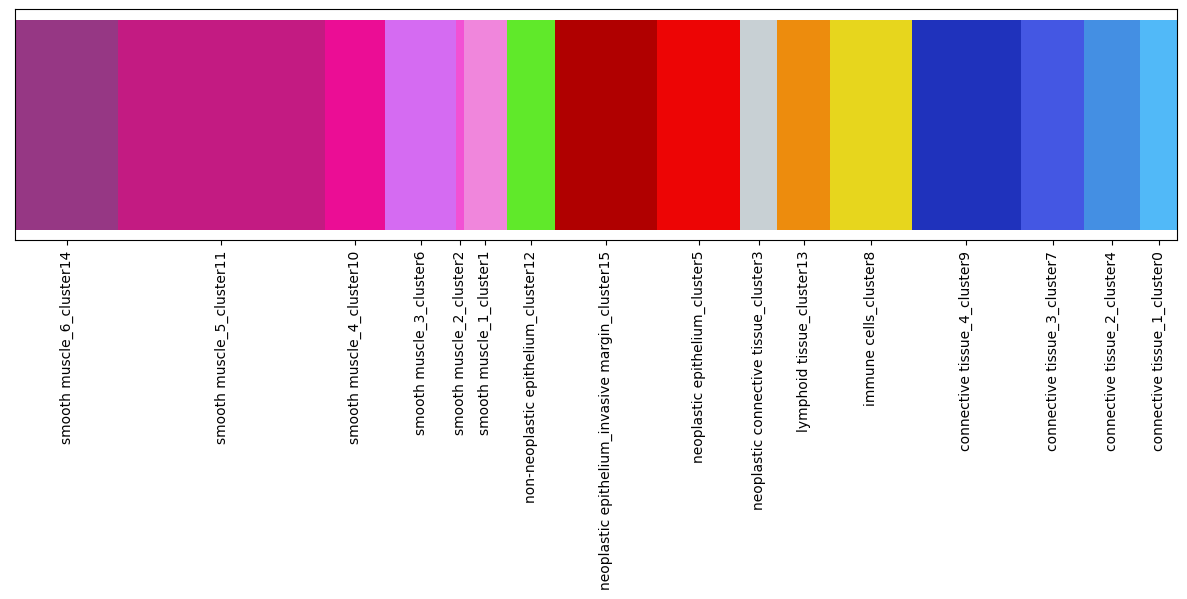

In [11]:
plt.figure(figsize=(15,3))


bar_edges=np.cumsum(list(colors.areas[celltype_sort_idcs])/colors.areas.sum())[::-1]
[plt.barh([0],c,color=colors.colors.values[celltype_sort_idcs[i]]) for i,c in enumerate(bar_edges)]

plt.xticks(bar_edges-colors.areas[celltype_sort_idcs][::-1]/2/colors.areas.sum(),colors.celltype[celltype_sort_idcs],rotation=90)

plt.yticks([],[])
plt.xlim(0,1)

plt.savefig(f'../../output/{sample_number}/celltype_distribution')


''

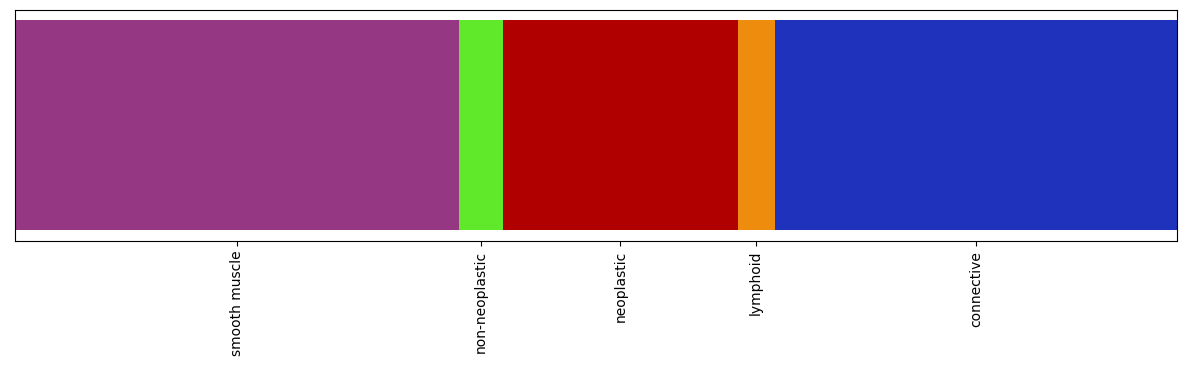

In [12]:
plt.figure(figsize=(15,3))

coi_areas=celltype_matrix.sum(-1).sum(-1)

bar_edges=np.cumsum(coi_areas/coi_areas.sum())[::-1]
[plt.barh([1],c,color=plotting_colors[i]) for i,c in enumerate(bar_edges)]

plt.xticks(bar_edges-coi_areas[::-1]/2/coi_areas.sum(),coi,rotation=90)

plt.yticks([],[])
plt.xlim(0,1)

plt.savefig(f'../../output/{sample_number}/categories_of_interest_distribution')


''